## Introduction to Data Version Control

Tutorial based on [DVC use cases](https://dvc.org/doc/use-cases/data-and-model-files-versioning), also see [DVC features](https://dvc.org/features).

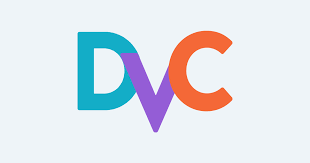

<br>
<br>

We are going to play with an actual Machine Learning scenario. It explores the NLP problem of predicting tags for a given StackOverflow
question. For example, we want one classifier which can predict a post that is about the Python language by tagging it python.

This tutorial has been made adopting [DVC get-Started tutorial](https://dvc.org/doc/get-started/agenda) and full credit goes to DVC team for making that.
A github repo for get-starter tutorial can be found [here](https://github.com/iterative/example-get-started).

## Installing DVC

Installing DVC is very easy. There are mainly three recommended ways:
- pip
- OS-specific package managers
- HomeBrew(for apple users)


We are going to install with `pip- Python package manger`. For other installation
methods checkout [here](https://dvc.org/doc/get-started/install)

In [ ]:
import warnings  
warnings.filterwarnings('ignore')

In [ ]:
# Installing DVC
! pip install dvc 

In [ ]:
# Checking out DVC installation
! dvc -h


## Initialising NLP Project

In [ ]:
! mkdir get-started && cd get-started

In [ ]:
from pathlib import Path
import os

a = Path.cwd() / "get-started"
os.chdir(a)

In [ ]:
# Initialising git in our folder
! git init

In [ ]:
# Run DVC initialization in a repository directory to create the DVC meta files and directories
! dvc init

In [ ]:
# configuring git for user account
! git config --global user.name "NAME" #Replace with your github username
! git config --global user.email "MAIL" #Replace with your email id
# commit the initialised git files
! git commit -m "initialize DVC"

## Configuring DVC remotes


A DVC remote is used to share your ML models and datasets with others. The various types of remotes DVC currently supports is:
https://dvc.org/doc/get-started/configure
- `local` - Local directory
- `s3` - Amazon Simple Storage Service
- `gs` - Google Cloud Storage
- `azure` - Azure Blob Storage
- `ssh` - Secure Shell
- `hdfs` - The Hadoop Distributed File System
- `http` - Support for HTTP and HTTPS protocolbucks

> Note we are using remote as a local directory as storage. **It's usually recommended to use Cloud storage services as DVC remote.**

[More information](https://dvc.org/doc/get-started/configure)

In [ ]:
! dvc remote add -d myremote /tmp/dvc-storage

In [ ]:
 ! git commit .dvc/config -m "initialize DVC local remote"

## Downloading files



In [ ]:
# Download the data
! mkdir data/
!  dvc get https://github.com/iterative/dataset-registry \
        get-started/data.xml -o data/data.xml

In [ ]:
# add file(directory) to DVC
! dvc add data/data.xml

In [ ]:
# add DVC files to git and update gitignore
! git add data/.gitignore data/data.xml.dvc
! git commit -m "add source data to DVC"

[more information](https://dvc.org/doc/get-started/add-files)

In [ ]:
#  push them from your repository to the default remote storage*:
! dvc push

## Retrieving Data

Now since we pushed our data, we are going to do the opposite of push ie `pull` similar to git analogy.
An easy way to test it is by removing currently downloaded data.

In [ ]:
! rm -f data/data.xml

In [ ]:
# Now your data returns back to repositary
! dvc pull

In [ ]:
# incase just to retrieve single dataset or file
! dvc pull data/data.xml.dvc

## Connecting with code

For providing full Machine Learning reproducibility. It is important to connect code with Datasets which are being reproducible by
using commands like `dvc add/push/pull`.



In [ ]:
# run these commands to get the sample code:
! wget wget https://code.dvc.org/get-started/code.zip
! unzip code.zip
! rm -f code.zip

Having installed the `src/prepare.py` script in your repo, the following command
transforms it into a reproducible
[stage](https://dvc.org/doc/user-guide/dvc-files-and-directories) for the ML pipeline we're
building (described in detail [in the documentation](https://dvc.org/doc/get-started/example-pipeline)).

Stages are run using dvc run [command] and options among which we use:

- d for dependency: specify an input file
- o for output: specify an output file ignored by git and tracked by dvc
- M for metric: specify an output file tracked by git
- f for file: specify the name of the dvc file.
- command: a bash command, mostly a python script invocation

In [ ]:
# Create a pipeline to create  folder data/prepared with files train.tsv and test.tsv
! dvc run -f prepare.dvc \
          -d src/prepare.py -d data/data.xml \
          -o data/prepared \
          python src/prepare.py data/data.xml

In [ ]:
!  git add data/.gitignore prepare.dvc
!  git commit -m "add data preparation stage"

In [ ]:
! dvc push

## Pipeline

Using `dvc run` multiple times, and specifying outputs of a command (stage) as dependencies in another one, we can describe a sequence of commands that gets to a desired result.
This is what we call a data pipeline or computational graph.



In [ ]:
# Lets create a second stage (after prepare.dvc, created in the previous chapter) to perform feature extraction
! dvc run -f featurize.dvc \
          -d src/featurization.py -d data/prepared/ \
          -o data/features \
           python src/featurization.py data/prepared data/features

In [ ]:
# A third stage for training the model
! dvc run -f train.dvc \
          -d src/train.py -d data/features \
          -o model.pkl \
          python src/train.py data/features model.pkl

In [ ]:
%%bash
git add data/.gitignore .gitignore featurize.dvc train.dvc
git commit -m "add featurization and train steps to the pipeline"
dvc push


## Pipelines Visualisation

In [ ]:
! dvc pipeline show --ascii train.dvc 

## Metrics

The last stage we would like to add to our pipeline is its the evaluation. Data science is a metric-driven R&D-like process and `dvc metrics` along with DVC metric 
files provide a framework to capture and compare experiments performance.


`evaluate.py` calculates AUC value using the test data set. It reads features from the `features/test.pkl` file and produces a DVC metric file - `auc.metric`. It is a special DVC output file type, in this case it's just a plain text file with a single number inside.

In [ ]:
! dvc run -f evaluate.dvc \
          -d src/evaluate.py -d model.pkl -d data/features \
          -M auc.metric \
          python src/evaluate.py model.pkl \
                 data/features auc.metric

> Please, refer to the [dvc metrics](https://dvc.org/doc/commands-reference/metrics) command documentation to see more available options and details.

In [ ]:
%%bash
git add evaluate.dvc auc.metric
git commit -m "add evaluation step to the pipeline"

In [ ]:
! dvc push

In [ ]:
# Tag as a checkpoint to cpmpare further experiments
! git tag -a "baseline-experiment" -m "baseline"

## Experiments

Data science process is inherently iterative and R&D like - data scientist may try many different approaches, different hyper-parameter values and "fail" 
many times before the required level of a metric is achieved.

We are modifying our feature extraction of our files. Inorder to use `bigrams`. We are increasing no of features and n_gram_range in our file `src/featurization.py`.

In [ ]:
%%writefile src/featurization.py
import os
import sys
import errno
import pandas as pd
import numpy as np
import scipy.sparse as sparse

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer

try:
    import cPickle as pickle
except ImportError:
    import pickle

np.set_printoptions(suppress=True)

if len(sys.argv) != 3 and len(sys.argv) != 5:
    sys.stderr.write('Arguments error. Usage:\n')
    sys.stderr.write('\tpython featurization.py data-dir-path features-dir-path\n')
    sys.exit(1)

train_input = os.path.join(sys.argv[1], 'train.tsv')
test_input = os.path.join(sys.argv[1], 'test.tsv')
train_output = os.path.join(sys.argv[2], 'train.pkl')
test_output = os.path.join(sys.argv[2], 'test.pkl')

try:
    reload(sys)
    sys.setdefaultencoding('utf-8')
except NameError:
    pass


def mkdir_p(path):
    try:
        os.makedirs(path)
    except OSError as exc:  # Python >2.5
        if exc.errno == errno.EEXIST and os.path.isdir(path):
            pass
        else:
            raise


def get_df(data):
    df = pd.read_csv(
        data,
        encoding='utf-8',
        header=None,
        delimiter='\t',
        names=['id', 'label', 'text']
    )
    sys.stderr.write('The input data frame {} size is {}\n'.format(data, df.shape))
    return df


def save_matrix(df, matrix, output):
    id_matrix = sparse.csr_matrix(df.id.astype(np.int64)).T
    label_matrix = sparse.csr_matrix(df.label.astype(np.int64)).T

    result = sparse.hstack([id_matrix, label_matrix, matrix], format='csr')

    msg = 'The output matrix {} size is {} and data type is {}\n'
    sys.stderr.write(msg.format(output, result.shape, result.dtype))

    with open(output, 'wb') as fd:
        pickle.dump(result, fd, pickle.HIGHEST_PROTOCOL)
    pass


mkdir_p(sys.argv[2])

# Generate train feature matrix
df_train = get_df(train_input)
train_words = np.array(df_train.text.str.lower().values.astype('U'))

bag_of_words = CountVectorizer(stop_words='english',
                               max_features=5000,
                              ngram_range=(1, 2),)
bag_of_words.fit(train_words)
train_words_binary_matrix = bag_of_words.transform(train_words)
tfidf = TfidfTransformer(smooth_idf=False)
tfidf.fit(train_words_binary_matrix)
train_words_tfidf_matrix = tfidf.transform(train_words_binary_matrix)

save_matrix(df_train, train_words_tfidf_matrix, train_output)

# Generate test feature matrix
df_test = get_df(test_input)
test_words = np.array(df_test.text.str.lower().values.astype('U'))
test_words_binary_matrix = bag_of_words.transform(test_words)
test_words_tfidf_matrix = tfidf.transform(test_words_binary_matrix)

save_matrix(df_test, test_words_tfidf_matrix, test_output)



## Reproduce

We described our first pipeline. Basically, we created a number of DVC-file. Each file describes a single stage we need to run (a pipeline) towards a final result.
Each depends on some data (either source data files or some intermediate results from another DVC-file file) and code files.

In [ ]:
# Using DVC Repro here 
! dvc repro train.dvc


In [ ]:
! git commit -a -m "bigram model"

In [ ]:
! git checkout baseline-experiment
! dvc checkout

## Compare Expermiments

DVC makes it easy to iterate on your project using Git commits with tags or Git branches. It provides a way to try different ideas, keep track of them, 
switch back and forth. To find the best performing experiment or track the progress, a special metric output type is supported in 
DVC (described in one of the previous steps).

In [ ]:
%%bash
git checkout master
dvc checkout
dvc repro evaluate.dvc

In [ ]:
%%bash
git commit -a -m "evaluate bigram model"
git tag -a "bigram-experiment" -m "bigrams"

In [ ]:
! dvc metrics show -T

## Get older Data files

The answer is the `dvc checkout` command, and we already touched briefly the process of switching between different data versions in the Experiments step of this get started guide.

In [ ]:
! git checkout baseline-experiment train.dvc
! dvc checkout train.dvc

In [ ]:
! git checkout baseline-experiment
! dvc checkout

References
----------

- https://dvc.org/doc/get-started
- https://medium.com/qonto-engineering/using-dvc-to-create-an-efficient-version-control-system-for-data-projects-96efd94355fe